In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def build_encoder(input_dim, latent_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,latent_dim)
    )

In [ ]:
def build_decoder(latent_dim, output_dim):
    return nn.Sequential(
        nn.Linear(latent_dim, ),
        nn.ReLU(),
        nn.Linear(10, output_dim)
    )

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = build_encoder(input_dim, latent_dim)
        self.decoder = build_decoder(latent_dim, input_dim)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

In [ ]:
def variance_regularization(latent, q):
    mean_latent = torch.mean(latent, dim=0, keepdim=True)  # Shape: (1, latent_dim)
    centered_latent = latent - mean_latent  # Shape: (batch_size, latent_dim)
    Q_sqrt = torch.sqrt(torch.diag(q))  # Q^(1/2), Shape: (latent_dim, latent_dim)
    weighted_centered = torch.matmul(centered_latent, Q_sqrt)  # Shape: (batch_size, latent_dim)
    reg_loss = torch.norm(weighted_centered, p='fro') ** 2

    return reg_loss


In [ ]:
# creating a dataset
np.random.seed(42)
n_samples = 1000
# Independent Variables
x1 = np.random.normal(0,1,n_samples)
x2 = np.random.normal(0,1,n_samples)
x3 = np.random.normal(0,1,n_samples)
# Dependent Varibles
x4 = np.sin(x1) + np.log(np.abs(x2))
x5 = np.exp(x3) + 0.2*x2**2
data = np.vstack([x1, x2, x3, x4, x5]).T


In [ ]:
print(data.shape)

(1000, 5)


In [ ]:
# Normalising the data
data = (data-data.mean(axis=0))/data.std(axis=0)

In [ ]:
# converting the data to tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

In [ ]:
  # Model parameters
input_dim = 5
latent_dim = 5
num_epochs = 1000
alpha,beta,gamma = 0.9,1.2,0.1

In [ ]:
results = []
latent_variances_all = []
reconstruction_losses = []
variance_losses = []
weight_losses = []

for q_scale in range(1, 11):
    q = torch.tensor([0.002, q_scale * 0.002, q_scale * 0.02, q_scale * 0.2, q_scale * 2], dtype=torch.float32)
    model = Autoencoder(input_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    mse_loss = nn.MSELoss()

    losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward Pass
        latent, reconstructed = model(data_tensor)
        reconstruction_loss = mse_loss(reconstructed, data_tensor)
        variance_loss = variance_regularization(latent, q)
        weight_loss = sum(p.pow(2.0).sum() for p in model.parameters())

        # Total Loss
        loss = alpha * reconstruction_loss + beta * variance_loss + gamma * weight_loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
        if(epoch==999):
          reconstruction_losses.append(reconstruction_loss.item())
          variance_losses.append(variance_loss.item())
          weight_losses.append(weight_loss.item())

    model.eval()
    latent, reconstructed = model(data_tensor)

    # Collect variances of each latent variable for the current q_scale
    latent_variances = torch.var(latent, dim=0).detach().numpy()
    latent_variances_all.append(latent_variances)
    print(f"reconstruction loss: {reconstruction_loss.item()}")
    print(f"variance loss: {variance_loss.item()}")
    print(f"weight loss: {weight_loss.item()}")

    # Append the q_scale, latent_variances, and the final loss to results
    results.append((q_scale, latent_variances, losses[-1]))




Epoch [50/1000], Loss: 1.4121
Epoch [100/1000], Loss: 1.2264
Epoch [150/1000], Loss: 1.1648
Epoch [200/1000], Loss: 1.1251
Epoch [250/1000], Loss: 1.0942
Epoch [300/1000], Loss: 1.0683
Epoch [350/1000], Loss: 1.0461
Epoch [400/1000], Loss: 1.0269
Epoch [450/1000], Loss: 1.0101
Epoch [500/1000], Loss: 0.9953
Epoch [550/1000], Loss: 0.9823
Epoch [600/1000], Loss: 0.9709
Epoch [650/1000], Loss: 0.9609
Epoch [700/1000], Loss: 0.9522
Epoch [750/1000], Loss: 0.9447
Epoch [800/1000], Loss: 0.9382
Epoch [850/1000], Loss: 0.9325
Epoch [900/1000], Loss: 0.9277
Epoch [950/1000], Loss: 0.9235
Epoch [1000/1000], Loss: 0.9200
reconstruction loss: 1.0
variance loss: 4.3725773139158264e-05
weight loss: 0.19906756281852722
Epoch [50/1000], Loss: 1.8916
Epoch [100/1000], Loss: 1.4549
Epoch [150/1000], Loss: 1.3186
Epoch [200/1000], Loss: 1.2389
Epoch [250/1000], Loss: 1.1826
Epoch [300/1000], Loss: 1.1398
Epoch [350/1000], Loss: 1.1055
Epoch [400/1000], Loss: 1.0771
Epoch [450/1000], Loss: 1.0530
Epoch 

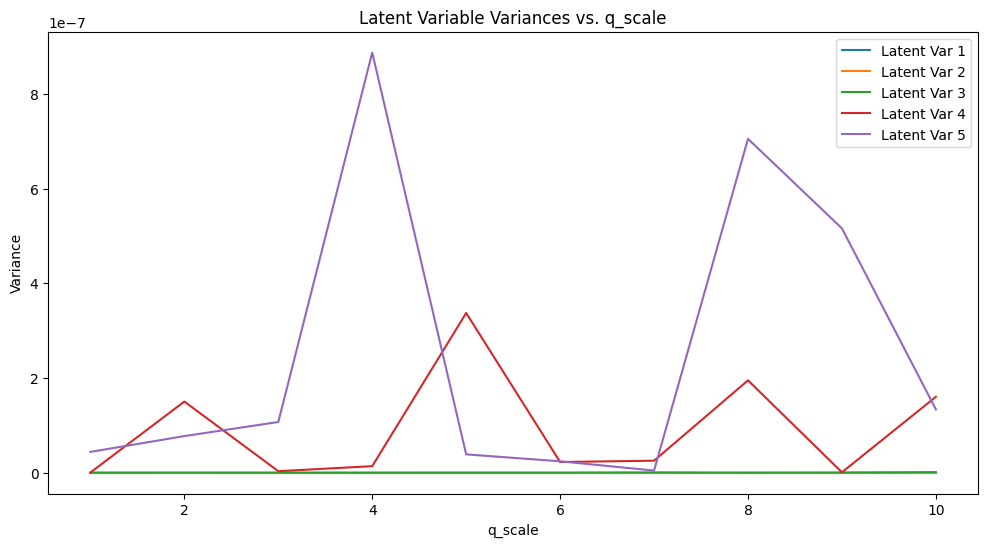

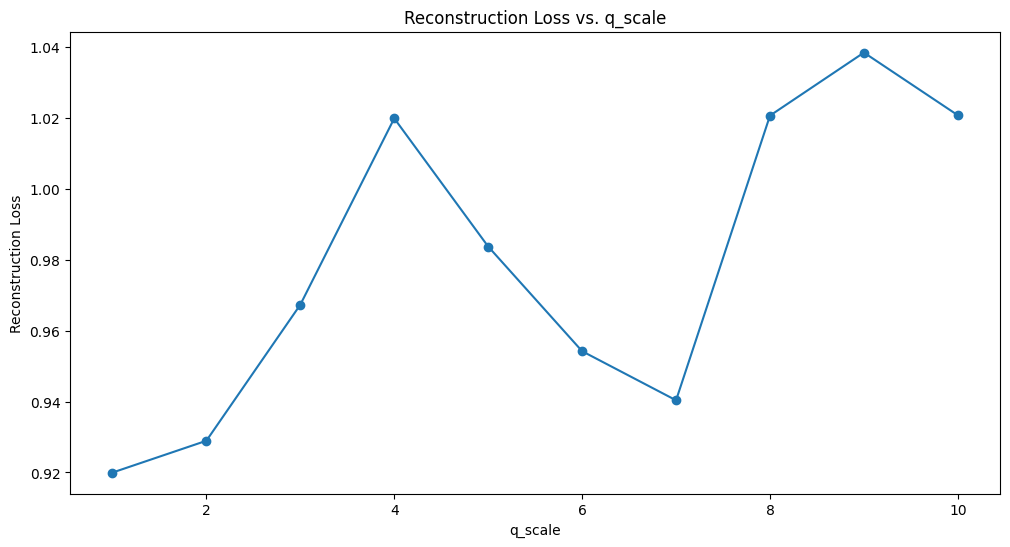

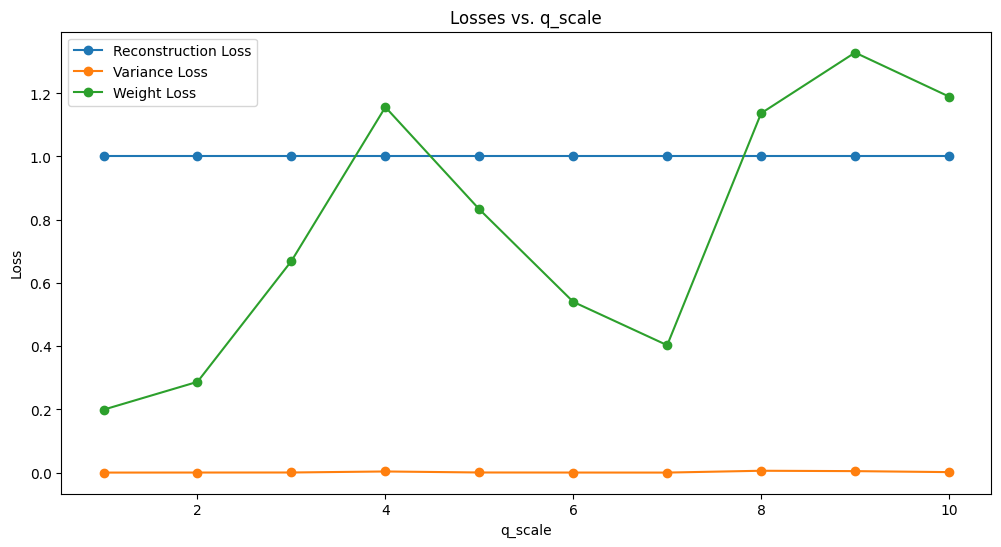

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(latent_dim):
    plt.plot(range(1, 11), [latent_variances_all[q_scale-1][i] for q_scale in range(1, 11)], label=f"Latent Var {i+1}")
plt.title("Latent Variable Variances vs. q_scale")
plt.xlabel("q_scale")
plt.ylabel("Variance")
plt.legend()
plt.show()

# Plotting the reconstruction loss vs q_scale
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), [loss for _, _, loss in results], marker='o')
plt.title("Reconstruction Loss vs. q_scale")
plt.xlabel("q_scale")
plt.ylabel("Reconstruction Loss")
plt.show()

# Plotting individual losses: Reconstruction, Variance, and Weight loss for each q_scale
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), reconstruction_losses, label="Reconstruction Loss", marker='o')
plt.plot(range(1, 11), variance_losses, label="Variance Loss", marker='o')
plt.plot(range(1, 11), weight_losses, label="Weight Loss", marker='o')
plt.title("Losses vs. q_scale")
plt.xlabel("q_scale")
plt.ylabel("Loss")
plt.legend()
plt.show()